# Zillow Clustering Project

In [1]:
import pandas as pd
import seaborn as sns
import acquire
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Acquire

## What does the data set look like?

In [2]:
df = acquire.zillow_data()
df

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,id,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,17173851,NaN,NaN,261.0,NaN,None,NaN,NaN,787,NaN,...,389.0,0.088469,2017-01-03,None,None,None,None,Single Family Residential,None,None
1,10821119,NaN,NaN,261.0,2.0,None,NaN,NaN,1702,NaN,...,402.0,0.025629,2017-01-03,None,None,None,Central,Single Family Residential,None,None
2,11007640,NaN,NaN,261.0,2.0,None,NaN,1.0,2412,NaN,...,2699.0,0.020360,2017-01-12,Central,None,None,Central,Single Family Residential,None,None
3,11457850,NaN,NaN,261.0,7.0,None,NaN,NaN,3770,NaN,...,2229.0,0.054233,2017-01-11,None,None,None,Floor/Wall,Single Family Residential,None,None
4,12591550,NaN,NaN,261.0,2.0,None,NaN,NaN,8197,NaN,...,3038.0,-0.016170,2017-01-13,None,None,None,Central,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,12885754,NaN,NaN,261.0,7.0,None,NaN,NaN,2976765,NaN,...,42657.0,0.515289,2017-06-01,None,None,None,Floor/Wall,Single Family Residential,None,None
52438,13869000,NaN,NaN,261.0,NaN,None,NaN,NaN,2977815,NaN,...,32297.0,0.009512,2017-05-02,None,None,None,None,Single Family Residential,None,None
52439,13890509,NaN,NaN,261.0,NaN,None,NaN,NaN,2977914,NaN,...,28537.0,-0.031048,2017-04-21,None,None,None,None,Single Family Residential,None,None
52440,17246810,NaN,NaN,261.0,NaN,None,NaN,NaN,2980979,NaN,...,8396.0,-0.031665,2017-02-07,None,None,None,None,Single Family Residential,None,None


In [3]:
df.logerror.mean()

0.018298494294412916

## Prepare

### Now that we have the dataset now we take a deeper look into it

What do the empty values look like?

In [4]:
df.isnull().sum()

parcelid                      0
typeconstructiontypeid    52366
storytypeid               52395
propertylandusetypeid         0
heatingorsystemtypeid     18507
                          ...  
buildingclassdesc         52442
heatingorsystemdesc       18507
propertylandusedesc           0
storydesc                 52395
typeconstructiondesc      52366
Length: 69, dtype: int64

There are many columns that have many empty values, let's get rid of them for the MVP.

In [5]:
df = acquire.handle_missing_values(df,prop_required_column=.9,prop_required_row=0)
df

,parcelid,propertylandusetypeid,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id,logerror,transactiondate,propertylandusedesc
0,17173851,261.0,787,2.0,4.0,2.0,1848.0,1848.0,6111.0,2.0,...,47193.0,64712.0,2016.0,17519.0,781.00,6.111004e+13,389.0,0.088469,2017-01-03,Single Family Residential
1,10821119,261.0,1702,2.0,2.0,2.0,1430.0,1430.0,6037.0,2.0,...,107511.0,381638.0,2016.0,274127.0,4692.27,6.037131e+13,402.0,0.025629,2017-01-03,Single Family Residential
2,11007640,261.0,2412,2.0,3.0,2.0,1572.0,1572.0,6037.0,2.0,...,144802.0,305307.0,2016.0,160505.0,3887.80,6.037106e+13,2699.0,0.020360,2017-01-12,Single Family Residential
3,11457850,261.0,3770,2.0,3.0,2.0,1412.0,1412.0,6037.0,2.0,...,38700.0,93146.0,2016.0,54446.0,1246.18,6.037276e+13,2229.0,0.054233,2017-01-11,Single Family Residential
4,12591550,261.0,8197,2.0,3.0,2.0,1352.0,1352.0,6037.0,2.0,...,96651.0,482242.0,2016.0,385591.0,6098.62,6.037544e+13,3038.0,-0.016170,2017-01-13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,12885754,261.0,2976765,1.0,3.0,1.0,1021.0,1021.0,6037.0,1.0,...,93397.0,200214.0,2016.0,106817.0,2629.33,6.037403e+13,42657.0,0.515289,2017-06-01,Single Family Residential
52438,13869000,261.0,2977815,2.0,4.0,2.0,1554.0,1554.0,6059.0,2.0,...,135043.0,215695.0,2016.0,80652.0,2607.04,6.059002e+13,32297.0,0.009512,2017-05-02,Single Family Residential
52439,13890509,261.0,2977914,4.0,3.0,4.0,2880.0,2880.0,6059.0,4.0,...,271027.0,1389962.0,2016.0,1118935.0,14935.72,6.059063e+13,28537.0,-0.031048,2017-04-21,Single Family Residential
52440,17246810,261.0,2980979,2.5,3.0,2.5,1376.0,1376.0,6111.0,2.0,...,201839.0,403678.0,2016.0,201839.0,4880.90,6.111008e+13,8396.0,-0.031665,2017-02-07,Single Family Residential


With this function I drop columns that are <90% empty, while they may hold valuable information. They will not be helpful for my MVP.

In [6]:
df.isnull().sum()

parcelid                           0
propertylandusetypeid              0
id                                 0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                138
calculatedfinishedsquarefeet      83
finishedsquarefeet12             248
fips                               0
fullbathcnt                      138
latitude                           0
longitude                          0
lotsizesquarefeet                369
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1037
regionidcounty                     0
regionidzip                       26
roomcnt                            0
yearbuilt                        117
structuretaxvaluedollarcnt        85
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              124
id                                 1
l

## This is enormous I have cut my dataset in HALF!!!!!!!
> - 52442 rows
> - 27854 rows

In [7]:
df.logerror.describe()

count    52441.000000
mean         0.018298
std          0.177501
min         -4.655420
25%         -0.024639
50%          0.007011
75%          0.040692
max          5.262999
Name: logerror, dtype: float64

> This is where the crux of where my investigation starts, since we want logerror I figure it be best that I focus in on it. To do this I have found the middle number of the 25% interval as well as the 75% interval. Which came out to around 0.035 To keep as many entries in tact as possible I bring it down to 0.03. This is the minimum. When looking for the cieling I had noticed that the top 20 entries of logerror were skewing the data the most. Setting the cieling to 2.5 cuts out about 40 entries. 40 out of 27 thousand is a drop in the bucket.

In [8]:
df = acquire.takeout_outliers1(df)
df

,parcelid,propertylandusetypeid,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id,logerror,transactiondate,propertylandusedesc
0,17173851,261.0,787,2.0,4.0,2.0,1848.0,1848.0,6111.0,2.0,...,47193.0,64712.0,2016.0,17519.0,781.00,6.111004e+13,389.0,0.088469,2017-01-03,Single Family Residential
3,11457850,261.0,3770,2.0,3.0,2.0,1412.0,1412.0,6037.0,2.0,...,38700.0,93146.0,2016.0,54446.0,1246.18,6.037276e+13,2229.0,0.054233,2017-01-11,Single Family Residential
5,12755884,261.0,8864,1.0,3.0,1.0,900.0,900.0,6037.0,1.0,...,51376.0,101313.0,2016.0,49937.0,1606.54,6.037553e+13,1192.0,0.442837,2017-01-06,Single Family Residential
6,13983750,261.0,10930,1.5,2.0,1.5,1213.0,1213.0,6059.0,1.0,...,47458.0,431697.0,2016.0,384239.0,5451.26,6.059042e+13,3247.0,0.087099,2017-01-17,Single Family Residential
8,14399561,261.0,12462,3.0,4.0,3.0,2834.0,2834.0,6059.0,3.0,...,398523.0,943142.0,2016.0,544619.0,9482.12,6.059063e+13,2883.0,0.032578,2017-01-13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52436,12087743,261.0,2973484,1.0,3.0,1.0,1539.0,1539.0,6037.0,1.0,...,21099.0,44056.0,2016.0,22957.0,595.93,6.037186e+13,31255.0,0.175492,2017-04-28,Single Family Residential
52437,12885754,261.0,2976765,1.0,3.0,1.0,1021.0,1021.0,6037.0,1.0,...,93397.0,200214.0,2016.0,106817.0,2629.33,6.037403e+13,42657.0,0.515289,2017-06-01,Single Family Residential
52439,13890509,261.0,2977914,4.0,3.0,4.0,2880.0,2880.0,6059.0,4.0,...,271027.0,1389962.0,2016.0,1118935.0,14935.72,6.059063e+13,28537.0,-0.031048,2017-04-21,Single Family Residential
52440,17246810,261.0,2980979,2.5,3.0,2.5,1376.0,1376.0,6111.0,2.0,...,201839.0,403678.0,2016.0,201839.0,4880.90,6.111008e+13,8396.0,-0.031665,2017-02-07,Single Family Residential


In [9]:
df.logerror.describe()

count    27854.000000
mean         0.031684
std          0.227680
min         -2.406257
25%         -0.054390
50%          0.037564
75%          0.079115
max          2.479045
Name: logerror, dtype: float64

With the function working we can now continue the exploration.

In [10]:
df = acquire.drop_cat_columns(df)

### Addressing nulls
Since so much of the data has been cut off I must focus on saving what I can. There are many valuable entries that have just some columns missing. So to keep them around I had filled in the empty values with zeros.

In [11]:
df = df.fillna(0)
df.shape

(27854, 18)

From this edited list now I split before exploring

In [12]:
train, validate, test = acquire.traintestsplit(df)
train, validate, test

(       bathroomcnt  bedroomcnt  calculatedbathnbr  \
 40731          1.0         3.0                1.0   
 1059           1.0         3.0                1.0   
 48642          2.0         4.0                2.0   
 42603          2.0         3.0                2.0   
 17181          2.0         3.0                2.0   
 ...            ...         ...                ...   
 39497          1.0         2.0                1.0   
 22243          1.0         4.0                1.0   
 5965           3.0         3.0                3.0   
 51844          3.0         4.0                3.0   
 21684          2.0         3.0                2.0   
 
        calculatedfinishedsquarefeet  finishedsquarefeet12  fullbathcnt  \
 40731                        1014.0                1014.0          1.0   
 1059                          972.0                 972.0          1.0   
 48642                        1375.0                1375.0          2.0   
 42603                        1504.0              

## Clustering

In [13]:
#this function is suppoused to give me scaled versions of my stuff
train_scaled, validate_scaled, test_scaled = acquire.splitmoreways(train, validate, test)
train_scaled, validate_scaled, test_scaled

(       bathroomcnt  bedroomcnt  calculatedbathnbr  \
 40731     0.090909         0.3           0.090909   
 1059      0.090909         0.3           0.090909   
 48642     0.181818         0.4           0.181818   
 42603     0.181818         0.3           0.181818   
 17181     0.181818         0.3           0.181818   
 ...            ...         ...                ...   
 39497     0.090909         0.2           0.090909   
 22243     0.090909         0.4           0.090909   
 5965      0.272727         0.3           0.272727   
 51844     0.272727         0.4           0.272727   
 21684     0.181818         0.3           0.181818   
 
        calculatedfinishedsquarefeet  finishedsquarefeet12  fullbathcnt  \
 40731                      0.058800              0.058800     0.090909   
 1059                       0.056364              0.056364     0.090909   
 48642                      0.079733              0.079733     0.181818   
 42603                      0.087214              

What do the clusters of logerror look like? What is best amount of clusters for logerror

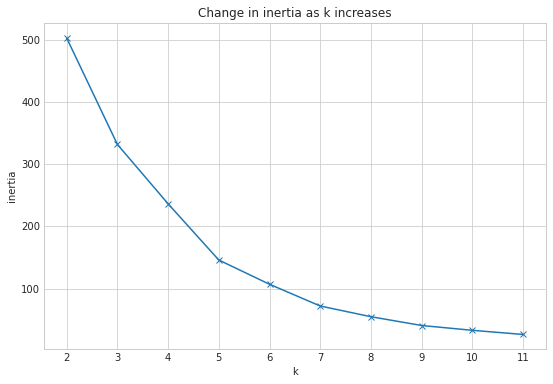

In [14]:
with plt.style.context('seaborn-whitegrid'):
    X = train_scaled[["logerror"]]
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

> 5, 6, 7 clusters

In [15]:
#label what we want clustered
X = train_scaled[["logerror"]]
#get the thing
kmeans = KMeans(n_clusters=6)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['cluster'] = kmeans.predict(X)

[4 0 0 ... 3 4 0]


What does that look like?

<AxesSubplot:xlabel='cluster', ylabel='logerror'>

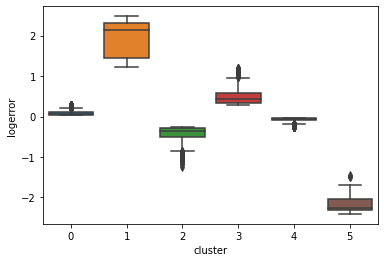

In [16]:
sns.boxplot(x="cluster", y="logerror", data=train)

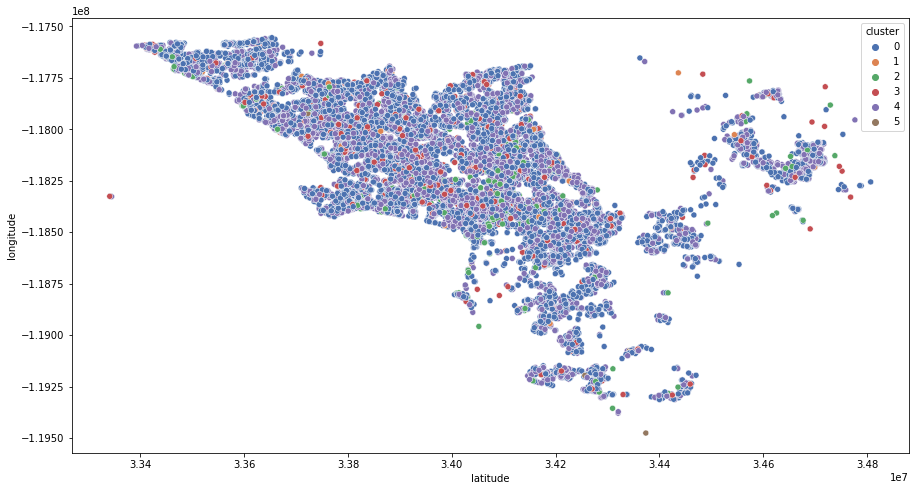

In [17]:
sns.scatterplot(x=train.latitude,y=train.longitude, hue=train.cluster, palette="deep")
plt.gcf().set_size_inches(15, 8)

This graph is a little hard to read I am going to bring the cluster amount down to 4

In [18]:
#label what we want clustered
X = train_scaled[["longitude","latitude"]]
#get the thing
kmeans = KMeans(n_clusters=6)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['longlat'] = kmeans.predict(X)

[4 1 3 ... 4 2 3]


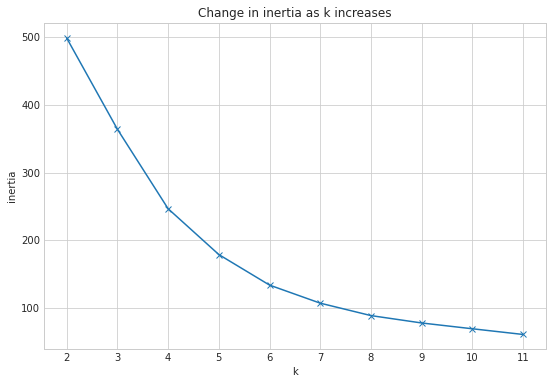

In [19]:
with plt.style.context('seaborn-whitegrid'):
    X = train_scaled[["longitude","latitude"]]
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## 6 columns for the long and lats
What I need to look up and understand is how I can make these into their own columns, alias them first maybe

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

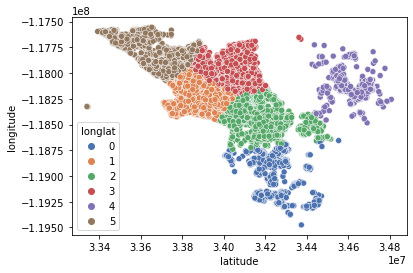

In [20]:
#wow okay it  even splits up the map to how many clusters I want
sns.scatterplot(x=train.latitude,y=train.longitude, hue=train.longlat, palette="deep")
#not very helpful to current scope/range but nice to look at

Ignore the above clustering from here I should bring in my top 5

## scaling

# Select K-best determined the following list of leading features

In [21]:
#as in bring in the select k-best
# parameters: f_regression stats test, give me 13 features
f_selector = SelectKBest(f_regression, k=18)

# find the top 8 X's correlated with y
f_selector.fit(train_scaled, train.logerror)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature
#these features also are great drivers for taxvaluedolarcnt which is then used in the zestimate

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror']

Need to check with elbow method to find optimal cluster amount

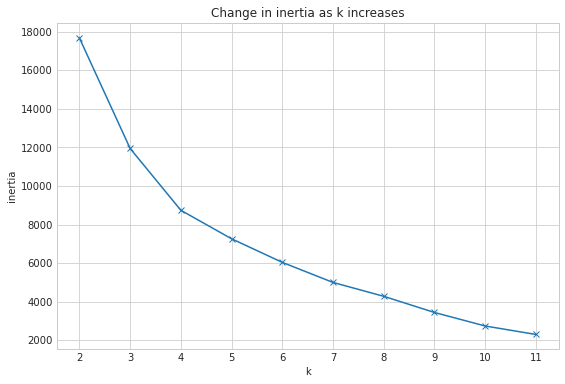

In [22]:
with plt.style.context('seaborn-whitegrid'):
    X = train[["bathroomcnt","bedroomcnt"]]
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

# Going with 7 clusters for bed and bath

In [23]:
#now that longitude and latitude are zoned what can
#lemme cluster between bed and baths
#label what we want clustered
X = train_scaled[["bathroomcnt","bedroomcnt"]]
#get the thing
kmeans = KMeans(n_clusters=7)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['bednbath'] = kmeans.predict(X)

[0 0 6 ... 4 1 0]


<AxesSubplot:xlabel='bedroomcnt', ylabel='bathroomcnt'>

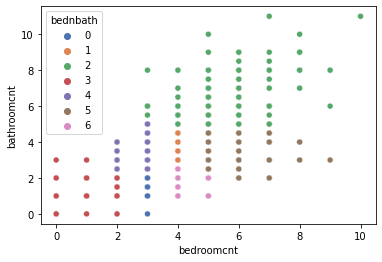

In [24]:
sns.scatterplot(x=train.bedroomcnt, y=train.bathroomcnt, hue=train.bednbath, palette="deep")

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

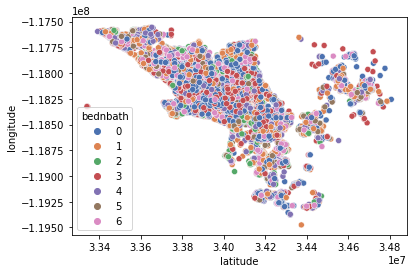

In [25]:
sns.scatterplot(x=train.latitude, y=train.longitude, hue=train.bednbath, palette="deep")

What is it exactly that I am looking for?

What is it that I need perciously?

Okay so this is gonna sound a little dumb but like let's make a cluster of all the clusters I want 

These will include:
- long lat
- bed bath

In [26]:
#the methodology for the method described above will be to run a select-K best model and pull my most heavy features

<b>
      <s>bathroomcntbedroomcnt</s>
 'calculatedbathnbr',
 <s>calculatedfinishedsquarefeet</s>
 'finishedsquarefeet12',
 'fullbathcnt',
     <s>latitudelongitude</s>
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'cluster',
 'zones'</b>

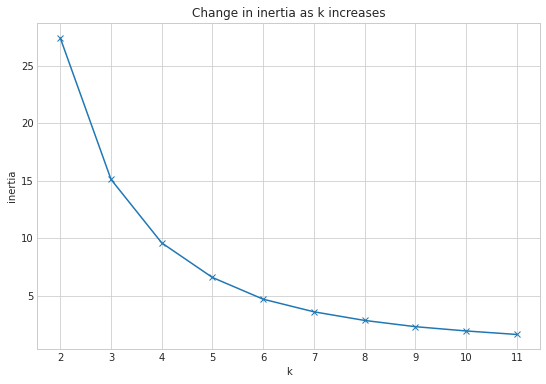

In [27]:
# calculatedfinishedsquarefeet clusters
with plt.style.context('seaborn-whitegrid'):
    X = train_scaled[["calculatedfinishedsquarefeet"]]
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [28]:
#now that longitude and latitude are zoned what can
#lemme cluster between bed and baths
#label what we want clustered
X = train_scaled[["calculatedfinishedsquarefeet"]]
#get the thing
kmeans = KMeans(n_clusters=6)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['squarefeet'] = kmeans.predict(X)
#going with 6

[0 0 0 ... 4 4 0]


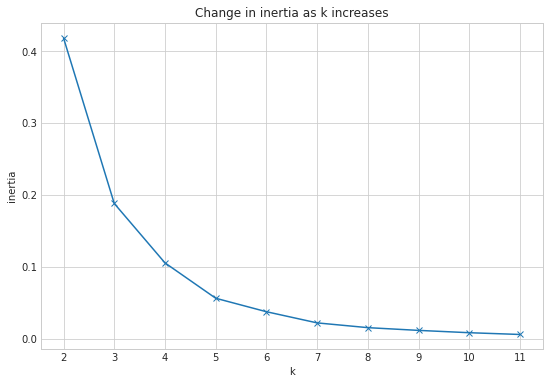

In [29]:
with plt.style.context('seaborn-whitegrid'):
    X = train_scaled[["lotsizesquarefeet"]]
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    #going with 5

In [30]:
X = train_scaled[["lotsizesquarefeet"]]
#get the thing
kmeans = KMeans(n_clusters=5)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['lotsize'] = kmeans.predict(X)

[0 0 0 ... 0 0 0]


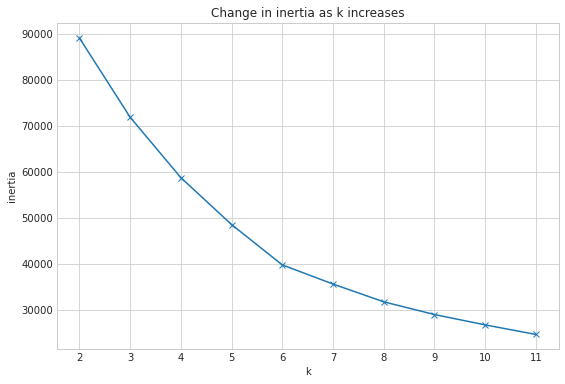

In [31]:
with plt.style.context('seaborn-whitegrid'):
    X = train[["squarefeet","lotsize","bednbath","longlat"]]
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    #going with 5

In [32]:
X = train[["squarefeet","lotsize","bednbath","longlat"]]
#get the thing
kmeans = KMeans(n_clusters=5)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['meta_cluster'] = kmeans.predict(X)

[1 1 4 ... 0 3 1]


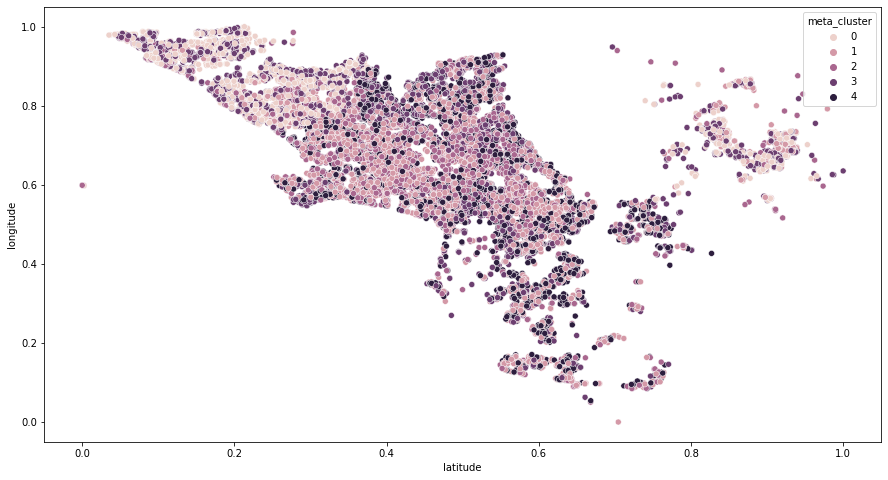

In [33]:
sns.scatterplot(x=train_scaled.latitude, y=train_scaled.longitude, hue=train.meta_cluster)
plt.gcf().set_size_inches(15, 8)

# Regression

In [34]:
# train, validate, test = acquire.traintestsplit(df)
# train, validate, test

## Modifying validate and test so that model can run

In [35]:
#label what we want clustered
X = validate_scaled[["longitude","latitude"]]
#get the thing
kmeans = KMeans(n_clusters=6)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
validate['longlat'] = kmeans.predict(X)

[0 4 3 ... 5 1 0]


In [36]:
#lemme cluster between bed and baths
#label what we want clustered
X = validate_scaled[["bathroomcnt","bedroomcnt"]]
#get the thing
kmeans = KMeans(n_clusters=7)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
validate['bednbath'] = kmeans.predict(X)

[3 2 3 ... 6 6 1]


In [37]:
#now that longitude and latitude are zoned what can
#lemme cluster between bed and baths
#label what we want clustered
X = validate_scaled[["calculatedfinishedsquarefeet"]]
#get the thing
kmeans = KMeans(n_clusters=6)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
validate['squarefeet'] = kmeans.predict(X)
#going with 6

[0 0 4 ... 4 4 1]


In [38]:
X = validate_scaled[["lotsizesquarefeet"]]
#get the thing
kmeans = KMeans(n_clusters=5)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
validate['lotsize'] = kmeans.predict(X)

[0 0 0 ... 0 0 0]


In [39]:
X = validate[["squarefeet","lotsize","bednbath","longlat"]]
#get the thing
kmeans = KMeans(n_clusters=5)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
validate['meta_cluster'] = kmeans.predict(X)

[0 4 2 ... 1 1 0]


## Adding in validate dataset

In [40]:
#label what we want clustered
X = test_scaled[["longitude","latitude"]]
#get the thing
kmeans = KMeans(n_clusters=6)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
test['longlat'] = kmeans.predict(X)

[1 4 2 ... 3 1 1]


In [41]:
#now that longitude and latitude are zoned what can
#lemme cluster between bed and baths
#label what we want clustered
X = test_scaled[["calculatedfinishedsquarefeet"]]
#get the thing
kmeans = KMeans(n_clusters=6)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
test['squarefeet'] = kmeans.predict(X)
#going with 6

[5 2 5 ... 2 5 2]


In [42]:
X = test_scaled[["lotsizesquarefeet"]]
#get the thing
kmeans = KMeans(n_clusters=5)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
test['lotsize'] = kmeans.predict(X)

[0 0 0 ... 0 0 0]


In [43]:
#lemme cluster between bed and baths
#label what we want clustered
X = test_scaled[["bathroomcnt","bedroomcnt"]]
#get the thing
kmeans = KMeans(n_clusters=7)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
test['bednbath'] = kmeans.predict(X)

[0 2 2 ... 0 5 2]


In [44]:
X = test[["squarefeet","lotsize","bednbath","longlat"]]
#get the thing
kmeans = KMeans(n_clusters=5)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
test['meta_cluster'] = kmeans.predict(X)

[2 4 2 ... 4 3 0]


## Adjusted code to add in metacluster to test dataset

I am now running into an error because my meta cluster is not in my validate and test dataset

> the solution to my problem

## Modeling & testing

The original baseline before the data clearing is:
> 0.018298494294412916

In [45]:
#the adjusted baseline is
train.logerror.mean()

0.03299599172922199

In [46]:
X_train = train[['meta_cluster']]
y_train = train[['logerror']]

X_validate = validate[['meta_cluster']]
y_validate = validate['logerror']

X_test = test[['meta_cluster']]
y_test = test['logerror']

In [47]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train)

# predict train
train_predictions = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, train_predictions)**(1/2)

# predict validate
validate_predictions = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate, validate_predictions)**(1/2)

#test
test_predictions = lm.predict(X_test)

rmse_test = mean_squared_error(y_test, test_predictions)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
          "\nTest Sample: ", rmse_test)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.2310049925583655 
Validation/Out-of-Sample:  0.22119669934416486 
Test Sample:  0.22601932636443886


In [48]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror)**(1/2)

# predict validate

y_validate['logerror'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.0 
Validation/Out-of-Sample:  0.0


In [49]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  6.938893903907228e-18 
Validation/Out-of-Sample:  6.938893903907228e-18


Of these my best model is the linear regression so it is my model and I ended up beating the baseline note that the baseline is adjusted for error